In [1]:
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/MyDrive/spark-3.0.3-bin-hadoop2.7.tgz
#!tar xf /content/drive/Shareddrives/DA231-2022-public/spark-3.0.3-bin-hadoop2.7.tgz

!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import findspark

findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

**T20 Cricket predictions and match analytics [2008-2020]**

Import libraries

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import percent_rank
from pyspark.sql import Window
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import countDistinct
from pyspark.sql.functions import col

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import isnan, when, count, col

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

Import Dataset

In [4]:
balldf = spark.read.csv('/content/drive/Shareddrives/DIR_DE_Scale/IPL Ball-by-Ball 2008-2020.csv',header=True)
matchdf = spark.read.csv('/content/drive/Shareddrives/DIR_DE_Scale/IPL Matches 2008-2020.csv',header=True)

Data Preparation and Cleaning

In [5]:
balldf = balldf.withColumn("id", balldf["id"].cast(IntegerType()))
balldf = balldf.withColumn("is_wicket", balldf["is_wicket"].cast(IntegerType()))
balldf = balldf.withColumn("batsman_runs", balldf["batsman_runs"].cast(IntegerType()))
balldf = balldf.withColumn("extra_runs", balldf["extra_runs"].cast(IntegerType()))
balldf = balldf.withColumn("total_runs", balldf["total_runs"].cast(IntegerType()))
balldf = balldf.withColumn("ball", balldf["ball"].cast(IntegerType()))

In [6]:
balldf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in balldf.columns]).show(vertical=True)

-RECORD 0---------------
 id               | 0   
 inning           | 0   
 over             | 0   
 ball             | 0   
 batsman          | 0   
 non_striker      | 0   
 bowler           | 0   
 batsman_runs     | 0   
 extra_runs       | 0   
 total_runs       | 0   
 non_boundary     | 0   
 is_wicket        | 0   
 dismissal_kind   | 0   
 player_dismissed | 0   
 fielder          | 0   
 extras_type      | 0   
 batting_team     | 0   
 bowling_team     | 0   



# Match Analytics for Batsman


Which players have most sixes in IPL?

+--------------+-----+
|       batsman|Sixes|
+--------------+-----+
|      CH Gayle|  349|
|AB de Villiers|  235|
|      MS Dhoni|  216|
|     RG Sharma|  214|
|       V Kohli|  202|
|    KA Pollard|  198|
|     DA Warner|  195|
|      SK Raina|  194|
|     SR Watson|  190|
|    RV Uthappa|  163|
+--------------+-----+
only showing top 10 rows



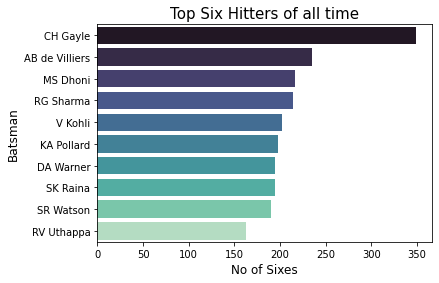

In [7]:
## filter run scores in "6" and create count for each batsman
batgroup = balldf.groupby('batsman')

sixes=balldf.filter(balldf.batsman_runs=='6')
sixes_df=sixes.groupBy('batsman').count().select('*').withColumnRenamed('count',"Sixes")
sixes_df.sort('Sixes',ascending=False).show(10)

top_10 = sixes_df.toPandas()
top_10.sort_values(by='Sixes',ascending=False,inplace=True)
temp = top_10.head(10)

c1 = sns.barplot(data = temp,y="batsman", x="Sixes",palette = 'mako')
plt.ylabel('Batsman',fontsize=12)
plt.xlabel('No of Sixes',fontsize=12)
plt.title('Top Six Hitters of all time',fontsize=15)
plt.show()

Which players have most runs in boundaries?

+--------------+------------------+
|       batsman|Runs in boundaries|
+--------------+------------------+
|      CH Gayle|               733|
|       V Kohli|               706|
|     DA Warner|               705|
|      S Dhawan|               700|
|      SK Raina|               687|
|     RG Sharma|               672|
|AB de Villiers|               625|
|    RV Uthappa|               617|
|     SR Watson|               566|
|     G Gambhir|               551|
+--------------+------------------+
only showing top 10 rows



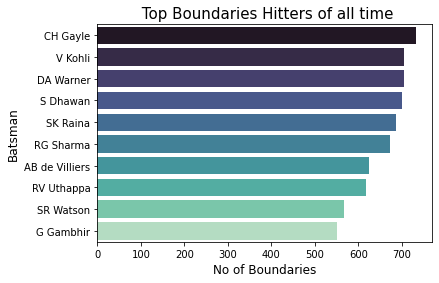

In [8]:
four_six=balldf.filter(balldf.batsman_runs.isin(4,6))
four_six=four_six.groupBy('batsman').count().select('*').withColumnRenamed('count',"Runs in boundaries")
four_six.sort('Runs in boundaries',ascending=False).show(10)

top_10 = four_six.toPandas()
top_10.sort_values(by='Runs in boundaries',ascending=False,inplace=True)
temp = top_10.head(10)

c1 = sns.barplot(data = temp,y="batsman", x="Runs in boundaries",palette = 'mako')
plt.ylabel('Batsman',fontsize=12)
plt.xlabel('No of Boundaries',fontsize=12)
plt.title(' Top Boundaries Hitters of all time',fontsize=15)
plt.show()

Who are the highest run getters in ipl?

+--------------+------------+
|       batsman|batsman_runs|
+--------------+------------+
|       V Kohli|        5878|
|      SK Raina|        5368|
|     DA Warner|        5254|
|     RG Sharma|        5230|
|      S Dhawan|        5197|
|AB de Villiers|        4849|
|      CH Gayle|        4772|
|      MS Dhoni|        4632|
|    RV Uthappa|        4607|
|     G Gambhir|        4217|
+--------------+------------+
only showing top 10 rows



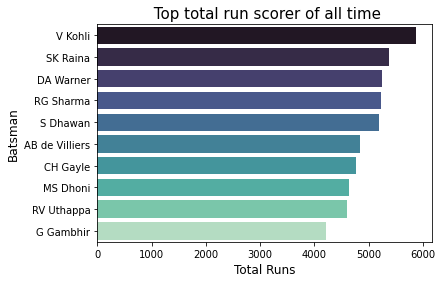

In [9]:
total_runs=balldf.groupBy('batsman').sum('batsman_runs')
total_runs=total_runs.select('*').withColumnRenamed('sum(batsman_runs)',"batsman_runs")
total_runs.sort('batsman_runs',ascending=False).show(10)

top_10 = total_runs.toPandas()
top_10.sort_values(by='batsman_runs',ascending=False,inplace=True)
temp = top_10.head(10)

c1 = sns.barplot(data = temp,y="batsman", x="batsman_runs",palette = 'mako')
plt.ylabel('Batsman',fontsize=12)
plt.xlabel('Total Runs',fontsize=12)
plt.title(' Top total run scorer of all time',fontsize=15)
plt.show()

Which players have best strike rate in death overs?

+--------------+--------------------+
|       batsman|Strike rate in death|
+--------------+--------------------+
|AB de Villiers|  215.84415584415584|
|       RR Pant|  207.72058823529412|
|    AD Russell|  195.12761020881672|
|      CH Gayle|  193.05555555555554|
|    MEK Hussey|   189.1304347826087|
|        N Rana|   188.9763779527559|
|     DA Warner|  184.94983277591973|
|     SV Samson|  184.91379310344828|
|       V Kohli|  182.53968253968253|
|      CL White|  182.41206030150755|
|     SR Watson|   180.4780876494024|
|     DA Miller|  176.74418604651163|
|     RG Sharma|  176.16209773539927|
|       KK Nair|  175.48387096774192|
|     DJ Hussey|   175.2136752136752|
|      KL Rahul|  174.62686567164178|
|  F du Plessis|  173.29842931937173|
|     GJ Bailey|  172.10526315789474|
|   BCJ Cutting|  171.42857142857142|
|     JH Kallis|  170.56277056277057|
+--------------+--------------------+
only showing top 20 rows



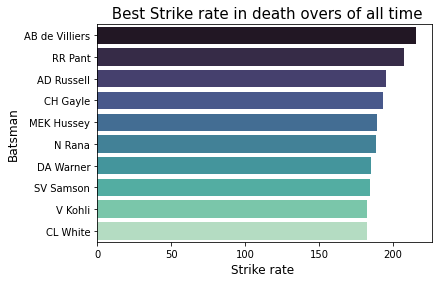

In [10]:
death=balldf[ (balldf['over'].between(15,19)) ]#filtering out wides and no balls, and taking  only powerplay overs(1-6) 
total_runs=death.groupBy('batsman').sum('batsman_runs')
runs_1=total_runs.select('*').withColumnRenamed('sum(batsman_runs)',"batsman_runs")
balls_1=death.groupby('batsman').count()#finding out total balls faced by each batsman

death_over=runs_1.join(balls_1,on='batsman')
result_12=death_over.withColumn("Strike rate in death", col("batsman_runs")*100/col("count")).sort('Strike rate in death',ascending=False)#Dividing the two columns and getting the strike rate the hard way.
death_runs=result_12[result_12['batsman_runs'] > 200]#players who have more than 200 runs in deaths
death_runs.select('batsman','Strike rate in death').show()

top_10 = death_runs.toPandas()
top_10.sort_values(by='Strike rate in death',ascending=False,inplace=True)
temp = top_10.head(10)

c1 = sns.barplot(data = temp,y="batsman", x="Strike rate in death",palette = 'mako')
plt.ylabel('Batsman',fontsize=12)
plt.xlabel('Strike rate ',fontsize=12)
plt.title(' Best Strike rate in death overs of all time',fontsize=15)
plt.show()

# Match Analytics for Bowler

Max Runs Conceived per Over

In [11]:
def barplot(ycol, xcol, ylabel, xlabel, title, temp):
  c1 = sns.barplot(data = temp, y = ycol, x = xcol, palette = 'mako')
  plt.ylabel(ylabel, fontsize=12)
  plt.xlabel(xlabel, fontsize=12)
  plt.title(title, fontsize=15)
  plt.show()

+-------+---------------+----+----+
|     id|         bowler|over|Runs|
+-------+---------------+----+----+
| 501247| P Parameswaran|   2|  37|
| 419139|      RS Bopara|  12|  33|
| 734047|        P Awana|   5|  33|
| 548327|       R Sharma|  12|  31|
|1216493|      CJ Jordan|  19|  30|
| 980987|      S Kaushik|  18|  30|
|1216496|        L Ngidi|  19|  30|
| 501260|JJ van der Wath|  14|  30|
| 335988|      A Symonds|  12|  30|
|1082592|       AB Dinda|  19|  30|
+-------+---------------+----+----+
only showing top 10 rows



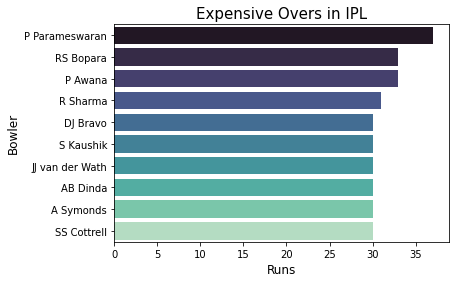

In [12]:
mRunsOverdf = balldf.groupby(['id','bowler','over']).agg(sum('total_runs').alias("Runs")).sort('Runs',ascending=False)#.show()
mRunsOverdf.show(10)

top_wick = mRunsOverdf.toPandas()
tempdata = top_wick.head(10)
barplot(ycol="bowler", xcol="Runs", ylabel="Bowler", xlabel="Runs", title="Expensive Overs in IPL", temp=tempdata)

**Which player has conceded least number of runs when bowled all 4 overs?**

+--------------+-------+-----+-------------------------------+
|        bowler|     id|count|Runs conceded in a single match|
+--------------+-------+-----+-------------------------------+
|    FH Edwards| 392184|   24|                              6|
|       A Nehra| 392226|   24|                              6|
|     YS Chahal|1175356|   24|                              6|
|   Rashid Khan|1216524|   24|                              7|
|      R Sharma| 501241|   24|                              7|
|   LH Ferguson|1082624|   25|                              7|
|    MG Johnson| 598055|   24|                              8|
| BW Hilfenhaus| 548361|   24|                              8|
|Mohammed Siraj|1216494|   24|                              8|
|      DR Smith| 981001|   25|                              8|
+--------------+-------+-----+-------------------------------+
only showing top 10 rows



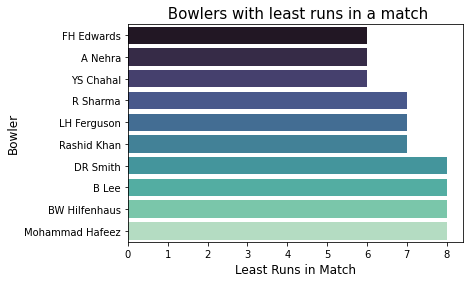

In [15]:
lst_runs=balldf.groupby(['id','bowler']).count()
extra=balldf.filter(~balldf.extras_type.isin('legbyes','byes'))
runs_con=extra.groupby(['id','bowler']).agg(sum('total_runs').alias("Runs conceded in a single match"))
joinsss=lst_runs.join(runs_con,on=['bowler','id'])

lstRunsdf = joinsss[joinsss['count'] >= 24].sort('Runs conceded in a single match',ascending=True)
lstRunsdf.show(10)
joinsspd = lstRunsdf.toPandas()
tempdata = joinsspd.head(10)
barplot(ycol="bowler", xcol="Runs conceded in a single match", ylabel="Bowler", xlabel="Least Runs in Match", title=" Bowlers with least runs in a match", temp=tempdata)

**bowler has best economic rate in ipl**

+-----------------+------------------+
|           bowler|     economic rate|
+-----------------+------------------+
|      Rashid Khan| 6.373983739837398|
|       GD McGrath| 6.777777777777778|
|         A Kumble| 6.849056603773585|
|        SP Narine|6.9049676025917925|
|   M Muralitharan| 6.909090909090909|
|Washington Sundar| 6.954128440366972|
|       DL Vettori|         6.9765625|
| RE van der Merwe|               7.0|
|         R Ashwin| 7.003738317757009|
|   AD Mascarenhas|7.0588235294117645|
+-----------------+------------------+
only showing top 10 rows



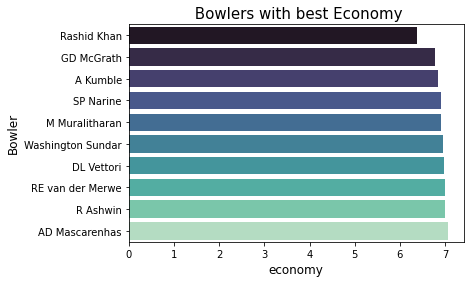

In [16]:
maxx=balldf.groupby(['id','bowler','over']).count()
max_over=maxx[maxx['count'] >= 6]
resm=max_over.groupby('bowler').count().sort('count',ascending=False)
#resm.show()

ext=balldf[~balldf['extras_type'].isin('byes','leg_byes')]#filetring out runs conceded by byes or leg byes
runs_concc=ext.groupby('bowler').sum('total_runs')

eco=resm.join(runs_concc,on='bowler')

bow_eco=eco.withColumn("economic rate", col('sum(total_runs)')/col("count")).sort('economic rate')
economic_rate=bow_eco[bow_eco['count'] > 50]
ecdf = economic_rate.select('bowler','economic rate')

ecdf.show(10)

ecopd = ecdf.toPandas()
tempdata = ecopd.head(10)
barplot(ycol="bowler", xcol="economic rate", ylabel="Bowler", xlabel="economy", title=" Bowlers with best Economy", temp=tempdata)

**Which bowlers have best economic rate in powerplay ipl?(only those have bowled over 30 overs)**

+-------------+------------------+
|       bowler|     economic rate|
+-------------+------------------+
|    JC Archer|5.4035087719298245|
|   GD McGrath| 5.891891891891892|
|   SM Pollock| 6.147058823529412|
|      B Kumar| 6.180672268907563|
|    SP Narine| 6.347107438016529|
|Iqbal Abdulla| 6.369565217391305|
|   WPUJC Vaas| 6.393939393939394|
|     DW Steyn| 6.417989417989418|
|   SL Malinga| 6.454054054054054|
|BW Hilfenhaus|               6.5|
+-------------+------------------+
only showing top 10 rows



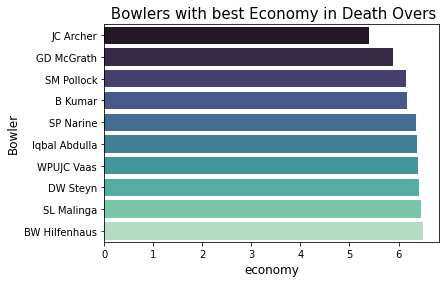

In [17]:
poww = balldf[balldf['over'].between(0,5)]
poww_play=poww.groupby(['id','bowler','over']).count()
poww_overs=poww_play[poww_play['count'] >= 6]
res_p=poww_overs.groupby('bowler').count()

po=balldf[(~balldf['extras_type'].isin('byes','leg_byes')) & (balldf['over'].between(0,5))]#filetring out runs conceded by byes or leg byes and only death overs
po_runs=po.groupby('bowler').sum('total_runs')

eco_pow=res_p.join(po_runs,on='bowler')



bow_eco_pow=eco_pow.withColumn("economic rate", col('sum(total_runs)')/col("count")).sort('economic rate')
economic_rate_pow=bow_eco_pow[bow_eco_pow['count'] > 30]
ecoDeath = economic_rate_pow.select('bowler','economic rate')
ecoDeath.show(10)

ecoDeathpd = ecoDeath.toPandas()
tempdata = ecoDeathpd.head(10)
barplot(ycol="bowler", xcol="economic rate", ylabel="Bowler", xlabel="economy", title=" Bowlers with best Economy in Death Overs", temp=tempdata)

**Which bowlers have taken most wickets in ipl?**

+---------------+--------------+
|         bowler|sum(is_wicket)|
+---------------+--------------+
|     SL Malinga|           170|
|       A Mishra|           160|
|      PP Chawla|           156|
|       DJ Bravo|           153|
|Harbhajan Singh|           150|
|       R Ashwin|           138|
|        B Kumar|           136|
|      SP Narine|           127|
|      YS Chahal|           121|
|       UT Yadav|           119|
+---------------+--------------+
only showing top 10 rows



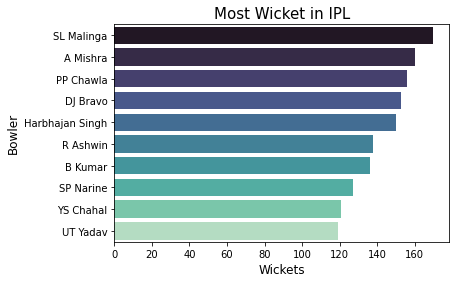

In [18]:
highest_wicket_taker=balldf[~balldf['dismissal_kind'].isin (['obstructing the field','run out']) ]#filtering out obstructing the field and run out dismissal kind 
result_2=highest_wicket_taker.groupBy('bowler').sum('is_wicket').sort('sum(is_wicket)',ascending=False)
result_2.show(10)


wickpd = result_2.toPandas()
tempdata = wickpd.head(10)
barplot(ycol="bowler", xcol="sum(is_wicket)", ylabel="Bowler", xlabel="Wickets", title="Most Wicket in IPL", temp=tempdata)


# Match Analytics for Team

In [42]:
batbowldf = balldf.filter((balldf.batsman=='V Kohli') & (balldf.bowler=='CRD Fernando'))

In [43]:
ballsf = batbowldf.count()    # Number of balls faced
print(ballsf)

totruns = batbowldf.agg({"batsman_runs":"sum"}).collect()[0][0]
print(totruns)

sr = (totruns / ballsf)*100

print(sr)

14
23
164.28571428571428


In [44]:
# Number of time bowler dismissed batsman

dismiss = batbowldf.filter(batbowldf.is_wicket != 0).count()
print(dismiss)

# Number of boundaries scored

batbowldf.filter(batbowldf.batsman_runs.isin(4,6)).count()

0


3

In [47]:
# Specifiying the teams playing and venue

team1 = 'Rajasthan Royals'
team2 = 'Chennai Super Kings'
venue = 'Sawai Mansingh Stadium'
matchstatdf = matchdf.filter(((matchdf.team1 == team1) & (matchdf.team2 == team2)) | ((matchdf.team1 == team2) & (matchdf.team2 == team1)))
#matchstatdf.show()
# Number of matches played
totplay = matchstatdf.count()
print(totplay)


23


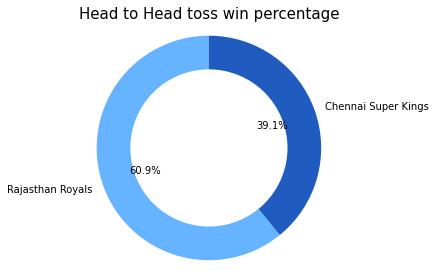

In [48]:
# Percentage toss win

team1toss = matchstatdf.filter(matchstatdf.toss_winner == team1).count()
team1tossper = (team1toss / totplay) * 100
#print(team1tossper)

team2toss = matchstatdf.filter(matchstatdf.toss_winner == team2).count()
team2tossper = (team2toss / totplay) * 100
#print(team2tossper)

# Plot

slices=[team1toss,team2toss]
labels=[team1,team2]
colors = ['#66b3ff','#205bc0','#94b5ef']

fig1, ax1 = plt.subplots()
ax1.pie(slices, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Head to Head toss win percentage",fontsize=15)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()


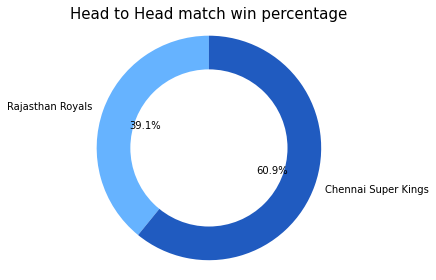

In [49]:
# Percentage match wins head to head

team1win = matchstatdf.filter(matchstatdf.winner == team1).count()
#print((team1win / totplay) * 100)

team2win = matchstatdf.filter(matchstatdf.winner == team2).count()
#print((team2win / totplay) * 100)

# Plot

slices=[team1win,team2win]
labels=[team1,team2]
colors = ['#66b3ff','#205bc0','#94b5ef']

fig1, ax1 = plt.subplots()
ax1.pie(slices, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Head to Head match win percentage",fontsize=15)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

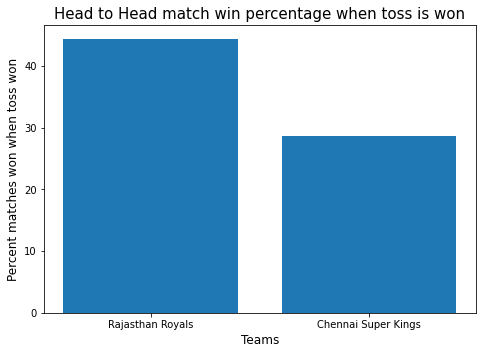

In [50]:
# For given team1 / team2 / toss venue below are stats
# If team1 wins toss, win percentage

toss_win1 = matchstatdf.filter((matchstatdf.toss_winner == team1) & (matchstatdf.winner == team1)).count()

# If team2 wins toss, win percentage

toss_win2 = matchstatdf.filter((matchstatdf.toss_winner == team2) & (matchstatdf.winner == team2)).count()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ticks = range(0,100,10)
ax.set_yticks(ticks)
teams = [team1,team2]
result = [((toss_win1 / team1win) * 100),((toss_win2 / team2win) * 100)]
ax.bar(teams,result)
plt.ylabel('Percent matches won when toss won',fontsize=12)
plt.xlabel('Teams',fontsize=12)
plt.title('Head to Head match win percentage when toss is won',fontsize=15)
plt.show()

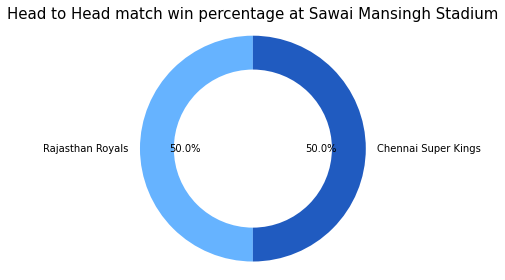

In [51]:
# Head to Head win stats at a venue

venuedf = matchstatdf.filter(matchstatdf.venue == venue)
#venuedf.show()

tot_play = venuedf.count()

team1_win = venuedf.filter(venuedf.winner == team1).count()

team2_win = venuedf.filter(venuedf.winner == team2).count()

# Plot

slices=[team1_win,team2_win]
labels=[team1,team2]
colors = ['#66b3ff','#205bc0','#94b5ef']

fig1, ax1 = plt.subplots()
ax1.pie(slices, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Head to Head match win percentage at " + venue ,fontsize=15)
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.show()

# Model for Batsman

Create test and train dataset

In [19]:
sorted_balldf = balldf.sort(balldf.id)
df = sorted_balldf.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy("id")))
train_balldf = df.where("rank <= .8").drop("rank")
test_balldf = df.where("rank > .8").drop("rank")

Train Dataset

In [20]:
# Group all batsman together and count number of ball faced
batgroup_train = train_balldf.groupby('batsman')
batdf=batgroup_train.count().select('*').withColumnRenamed('count',"ball_faced")

# count number of innings played by each batsman
innings_df=train_balldf.groupby('batsman').agg(countDistinct('id')).withColumnRenamed('count(id)',"Innings")
joined_df_train=batdf.join(innings_df,on='Batsman',how='left_outer')

## filter run scores in "4" and "6" and create count for each batsman
four=train_balldf.filter(train_balldf.batsman_runs=='4')
four_df=four.groupBy('batsman').count().select('*').withColumnRenamed('count',"Fours")
joined_df_train=joined_df_train.join(four_df,on='Batsman',how='left_outer')

sixes=train_balldf.filter(train_balldf.batsman_runs=='6')
sixes_df=sixes.groupBy('batsman').count().select('*').withColumnRenamed('count',"Sixes")
joined_df_train=joined_df_train.join(sixes_df,on='Batsman',how='left_outer')


In [21]:
# calculate batsman average
player_dismissed=train_balldf.groupby('player_dismissed').count()#Counting number of times a player is dismissed
total_runs=train_balldf.groupBy('batsman').sum('batsman_runs')
joined_data=player_dismissed.join(total_runs, player_dismissed.player_dismissed == total_runs.batsman, 'inner')
avg_df=joined_data.withColumn("Batsmen Avg", col("sum(batsman_runs)")/col("count")).sort('Batsmen Avg',ascending=False)#Dividing runs by number of times they have been dismissed
avg_df=avg_df.select('batsman','Batsmen Avg')
joined_df_train=joined_df_train.join(avg_df,on='batsman',how='left_outer')

# calcualte batsman total runs and strike rate
joined_df_train=joined_df_train.join(total_runs,on='batsman',how='left_outer').select('*').withColumnRenamed('sum(batsman_runs)',"Total_runs")

# calculate strike rate
joined_df_train=joined_df_train.withColumn("Strike rate", col('Total_runs')*100/col("ball_faced"))

# Runs per match
joined_df_train=joined_df_train.withColumn("Runs_per_match", col('Total_runs')/col("Innings"))

joined_df_train=joined_df_train.na.fill(value=0)
joined_df_train.show()

+---------------+----------+-------+-----+-----+------------------+----------+------------------+------------------+
|        batsman|ball_faced|Innings|Fours|Sixes|       Batsmen Avg|Total_runs|       Strike rate|    Runs_per_match|
+---------------+----------+-------+-----+-----+------------------+----------+------------------+------------------+
| A Ashish Reddy|       196|     23|   16|   15|18.666666666666668|       280|142.85714285714286|12.173913043478262|
|     A Chandila|         7|      2|    0|    0|               0.0|         4|57.142857142857146|               2.0|
|       A Chopra|        75|      6|    7|    0| 8.833333333333334|        53| 70.66666666666667| 8.833333333333334|
|    A Choudhary|        20|      3|    1|    1|              25.0|        25|             125.0| 8.333333333333334|
|    A Dananjaya|         5|      1|    0|    0|               0.0|         4|              80.0|               4.0|
|     A Flintoff|        57|      3|    5|    2|              31

Test Data


In [22]:
# Group all batsman together and count number of ball faced
batgroup_test = test_balldf.groupby('batsman')
batdf=batgroup_test.count().select('*').withColumnRenamed('count',"ball_faced")

# count number of innings played by each batsman
innings_df=test_balldf.groupby('batsman').agg(countDistinct('id')).withColumnRenamed('count(id)',"Innings")
joined_df_test=batdf.join(innings_df,on='Batsman',how='left_outer')

## filter run scores in "4" and "6" and create count for each batsman
four=test_balldf.filter(test_balldf.batsman_runs=='4')
four_df=four.groupBy('batsman').count().select('*').withColumnRenamed('count',"Fours")
joined_df_test=joined_df_test.join(four_df,on='Batsman',how='left_outer')

sixes=test_balldf.filter(test_balldf.batsman_runs=='6')
sixes_df=sixes.groupBy('batsman').count().select('*').withColumnRenamed('count',"Sixes")
joined_df_test=joined_df_test.join(sixes_df,on='Batsman',how='left_outer')

In [23]:
# calculate batsman average
player_dismissed=test_balldf.groupby('player_dismissed').count()#Counting number of times a player is dismissed
total_runs=test_balldf.groupBy('batsman').sum('batsman_runs')
joined_data=player_dismissed.join(total_runs, player_dismissed.player_dismissed == total_runs.batsman, 'inner')
avg_df=joined_data.withColumn("Batsmen Avg", col("sum(batsman_runs)")/col("count")).sort('Batsmen Avg',ascending=False)#Dividing runs by number of times they have been dismissed
avg_df=avg_df.select('batsman','Batsmen Avg')
joined_df_test=joined_df_test.join(avg_df,on='batsman',how='left_outer')

# calcualte batsman total runs and strike rate
joined_df_test=joined_df_test.join(total_runs,on='batsman',how='left_outer').select('*').withColumnRenamed('sum(batsman_runs)',"Total_runs")

# calculate strike rate
joined_df_test=joined_df_test.withColumn("Strike rate", col('Total_runs')*100/col("ball_faced"))

# Runs per match
joined_df_test=joined_df_test.withColumn("Runs_per_match", col('Total_runs')/col("Innings"))

joined_df_test=joined_df_test.na.fill(value=0)
joined_df_test.show()

+---------------+----------+-------+-----+-----+------------------+----------+------------------+------------------+
|        batsman|ball_faced|Innings|Fours|Sixes|       Batsmen Avg|Total_runs|       Strike rate|    Runs_per_match|
+---------------+----------+-------+-----+-----+------------------+----------+------------------+------------------+
|       A Mishra|        28|      5|    2|    0|              11.0|        22| 78.57142857142857|               4.4|
|       A Nortje|         6|      3|    0|    0|               7.0|         7|116.66666666666667|2.3333333333333335|
| AB de Villiers|       743|     33|   89|   64|             46.56|      1164| 156.6621803499327| 35.27272727272727|
|       AD Hales|       119|      6|   13|    6|24.666666666666668|       148|124.36974789915966|24.666666666666668|
|        AD Nath|        71|      6|    6|    2|11.666666666666666|        70| 98.59154929577464|11.666666666666666|
|     AD Russell|       458|     31|   52|   73|              31

Model Fitting

In [24]:
# filtering out test 'batsman' data for which in training 'batsman' is not present
only_test = joined_df_test.join(joined_df_train,on='batsman', how='left_anti')
# now dropping 'batsman' in test data which were not present in training set 'batsman'
final_test = joined_df_test.join(only_test,on='batsman', how='left_anti')

In [25]:
#Selecting features for training
vecAssembler = VectorAssembler(inputCols = joined_df_train.columns[1:-1], outputCol = 'features')

#Transforming features as vectors for training
train_df = vecAssembler.transform(joined_df_train)
train_df = train_df.select(['features', 'Runs_per_match'])
#Visualizing training parameters
train_df.show(3)

#Training the model
lr = LinearRegression(featuresCol = 'features', labelCol='Runs_per_match', maxIter=10)
# lr = LinearRegression(featuresCol = 'features', labelCol='Runs_per_match', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)

#Model parameters after training
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


+--------------------+------------------+
|            features|    Runs_per_match|
+--------------------+------------------+
|[196.0,23.0,16.0,...|12.173913043478262|
|[7.0,2.0,0.0,0.0,...|               2.0|
|[75.0,6.0,7.0,0.0...| 8.833333333333334|
+--------------------+------------------+
only showing top 3 rows

Coefficients: [0.021448931088499722,-0.1322377944461436,0.06386132256414079,0.09670003664161657,0.5545663372585766,-0.019257538928299445,0.033634192552588225]
Intercept: -0.4263547445855505
RMSE: 3.290875
r2: 0.859331


In [26]:
#Selecting features for test
vecAssembler = VectorAssembler(inputCols = final_test.columns[1:-1], outputCol = 'features')

#Evaluation on test data
test_df = vecAssembler.transform(final_test)
test_df = test_df.select(['batsman','features', 'Runs_per_match'])
#Visualization of test parameters
test_df.show(3)

#Prediction on test data and test results
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("batsman","prediction","Runs_per_match","features").show(5)
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Runs_per_match",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+--------------+--------------------+------------------+
|       batsman|            features|    Runs_per_match|
+--------------+--------------------+------------------+
|      A Mishra|[28.0,5.0,2.0,0.0...|               4.4|
|AB de Villiers|[743.0,33.0,89.0,...| 35.27272727272727|
|       AD Nath|[71.0,6.0,6.0,2.0...|11.666666666666666|
+--------------+--------------------+------------------+
only showing top 3 rows

+--------------+------------------+------------------+--------------------+
|       batsman|        prediction|    Runs_per_match|            features|
+--------------+------------------+------------------+--------------------+
|      A Mishra| 7.959999409915122|               4.4|[28.0,5.0,2.0,0.0...|
|AB de Villiers|31.692853180535707| 35.27272727272727|[743.0,33.0,89.0,...|
|       AD Nath| 9.317620634130325|11.666666666666666|[71.0,6.0,6.0,2.0...|
|    AD Russell|23.687458800854273|25.161290322580644|[458.0,31.0,52.0,...|
|      AJ Finch|16.447596725917073|21.555555

# Demo for Batsman

Batsman Run Prediction

In [27]:
TEAM_A = ['AT Rayudu','F du Plessis','SM Curran','MS Dhoni','M Vijay','SR Watson','DL Chahar', 'SM Curran', 'L Ngidi', 'PP Chawla', 'RA Jadeja']

In [28]:
TEAM_B = ['RG Sharma','AM Rahane','SA Yadav','HH Pandya','KA Pollard','SK Raina','KM Jadhav','KH Pandya' ,'AM Rahane','RA Tripathi']

In [29]:
result_df = lr_predictions.select('batsman','Runs_per_match','prediction').where(col("batsman").isin(TEAM_A))
result_df.show()

+------------+------------------+------------------+
|     batsman|    Runs_per_match|        prediction|
+------------+------------------+------------------+
|   AT Rayudu|            28.025|27.032296628139367|
|   DL Chahar|               8.0|10.210889220916163|
|F du Plessis|32.483870967741936|27.368542977523397|
|     M Vijay|              19.2|13.773983424243786|
|    MS Dhoni| 27.34285714285714| 38.39240986685326|
|   PP Chawla|             8.375| 8.800036468520913|
|   RA Jadeja|15.958333333333334| 22.49445134824216|
|   SR Watson|27.615384615384617|24.430699174047955|
+------------+------------------+------------------+



In [30]:
result_df = lr_predictions.select('batsman','Runs_per_match','prediction').where(col("batsman").isin(TEAM_B))
result_df.show()

+-----------+------------------+------------------+
|    batsman|    Runs_per_match|        prediction|
+-----------+------------------+------------------+
|  AM Rahane|24.333333333333332|19.364710898654707|
|  HH Pandya|23.736842105263158|24.511370674406017|
| KA Pollard|22.310344827586206|25.474407447971018|
|  KH Pandya|12.882352941176471|12.735906262394414|
|  KM Jadhav|13.176470588235293|13.601248254791708|
|RA Tripathi|             21.24|  17.5693858847777|
|  RG Sharma| 23.91891891891892|20.607379801497075|
|   SA Yadav|              32.3| 28.07090203189713|
|   SK Raina|26.344827586206897|22.676072682564786|
+-----------+------------------+------------------+



Plot for Prediction

In [31]:
batsman= result_df.toPandas()['batsman'].tolist()
avg_score= result_df.toPandas()['Runs_per_match'].tolist()
pred_score = result_df.toPandas()['prediction'].tolist()

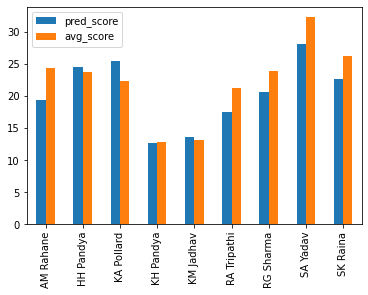

In [32]:
import pandas as pd
df = pd.DataFrame({'pred_score': pred_score,
                   'avg_score': avg_score}, index=batsman)
ax = df.plot.bar(rot='vertical')

# Model for Bowler

Train Dataset

In [33]:
ballgroup = train_balldf.groupby('bowler')
bowlerdf = ballgroup.count().select('*').withColumnRenamed('count',"num_balls")

runsdf = ballgroup.sum('total_runs').withColumnRenamed('sum(total_runs)', 'runs_given')

four=train_balldf.filter(train_balldf.batsman_runs=='4')
four_df=four.groupBy('bowler').count().select('*').withColumnRenamed('count',"Fours")

extrasdf = train_balldf.groupby("bowler").sum("extra_runs").withColumnRenamed("sum(extra_runs)","Extras")
innings_df=ballgroup.agg(countDistinct('id')).withColumnRenamed('count(id)',"Innings")

wickets = train_balldf.filter(train_balldf.is_wicket != 0)
wicketsdf= wickets.groupBy('bowler').count().select('*').withColumnRenamed('count', "Wickets")

sixes=train_balldf.filter(train_balldf.batsman_runs=='6')
six_df=sixes.groupBy('bowler').count().select('*').withColumnRenamed('count',"Sixes")

joindf_train = bowlerdf.join(runsdf, on='bowler', how='left_outer')
joindf_train = joindf_train.withColumn("Economy", (col("runs_given")/col("num_balls")) * 6)

joindf_train = joindf_train.join(innings_df, on='bowler', how='left_outer')
joindf_train = joindf_train.join(wicketsdf, on='bowler', how='left_outer')
joindf_train = joindf_train.withColumn("Wickets_per_match", (col("wickets")/col("Innings")))

joindf_train = joindf_train.withColumn("Runsgiven_per_match", (col("runs_given")/col("Innings")))

joindf_train = joindf_train.withColumn("Overs", (col("num_balls")/6))
joindf_train = joindf_train.filter(col("Overs") >= 30)
joindf_train = joindf_train.join(extrasdf, on='bowler', how = 'left_outer')
joindf_train = joindf_train.join(four_df, on='bowler', how = 'left_outer')
joindf_train = joindf_train.join(six_df, on='bowler', how = 'left_outer')

joindf_train = joindf_train.na.fill(value=0)

Test data

In [34]:
tballgroup = test_balldf.groupby('bowler')
tbowlerdf = tballgroup.count().select('*').withColumnRenamed('count',"num_balls")
trunsdf = tballgroup.sum('total_runs').withColumnRenamed('sum(total_runs)', 'runs_given')

joindf_test = tbowlerdf.join(trunsdf, on='bowler', how='left_outer')
joindf_test = joindf_test.withColumn("Economy", (col("runs_given")/col("num_balls")) * 6)

tinnings_df = tballgroup.agg(countDistinct('id')).withColumnRenamed('count(id)',"Innings")
joindf_test = joindf_test.join(tinnings_df, on='bowler', how='left_outer')

twickets = test_balldf.filter(test_balldf.is_wicket != 0)
twicketsdf= twickets.groupBy('bowler').count().select('*').withColumnRenamed('count', "Wickets")
twicketsdf.na.fill(value=0)

joindf_test = joindf_test.join(twicketsdf, on='bowler', how='left_outer')
joindf_test = joindf_test.withColumn("Wickets_per_match", (col("wickets")/col("Innings")))

joindf_test = joindf_test.withColumn("Runsgiven_per_match", (col("runs_given")/col("Innings")))

textrasdf = test_balldf.groupby("bowler").sum("extra_runs").withColumnRenamed("sum(extra_runs)","Extras")
tsixes = test_balldf.filter(test_balldf.batsman_runs=='6')
tsix_df = tsixes.groupBy('bowler').count().select('*').withColumnRenamed('count',"Sixes")
tfour = test_balldf.filter(test_balldf.batsman_runs=='4')
tfour_df = tfour.groupBy('bowler').count().select('*').withColumnRenamed('count',"Fours")

joindf_test = joindf_test.withColumn("Overs", (col("num_balls")/6))
joindf_test = joindf_test.filter(col("Overs") >= 30)
joindf_test = joindf_test.join(textrasdf, on='bowler', how = 'left_outer')
joindf_test = joindf_test.join(tfour_df, on='bowler', how = 'left_outer')
joindf_test = joindf_test.join(tsix_df, on='bowler', how = 'left_outer')

joindf_test = joindf_test.na.fill(value=0)


Model Fitting

In [35]:
# filtering out test 'bowler' data for which in training 'batsman' is not present
only_test = joindf_test.join(joindf_train, on='bowler', how='left_anti')

# now dropping 'bowler' in test data which were not present in training set 'bowler'
test_final = joindf_test.join(only_test,on='bowler', how='left_anti')

In [36]:
x = joindf_train.drop('bowler')
x = x.drop('Economy')

vecAssembler = VectorAssembler(inputCols = x.columns, outputCol = 'features')

train_df = vecAssembler.transform(joindf_train)
train_df = train_df.select(['features', 'Economy'])
train_df.show(3)

lr = LinearRegression(featuresCol = 'features', labelCol='Economy', maxIter=30, regParam=0.0, elasticNetParam=0.0)

lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


+--------------------+------------------+
|            features|           Economy|
+--------------------+------------------+
|[2276.0,2860.0,99...| 7.539543057996484|
|[1799.0,2348.0,89...|7.8310172317954425|
|[2637.0,3342.0,11...| 7.604095563139931|
+--------------------+------------------+
only showing top 3 rows

Coefficients: [-0.003040719308171543,0.001027394959831889,0.040572675176004803,0.026700113960320335,-1.2388188072440682,0.10547232382819742,-0.018244315849042615,0.0033663261187326255,0.004643395416414131,0.01603426543537605]
Intercept: 6.340475949561679
RMSE: 0.420325
r2: 0.634378


In [37]:
x = test_final.drop('bowler')

#x = x.drop('Economy')
x = x.drop('Economy')

vecA = VectorAssembler(inputCols = x.columns, outputCol = 'features')

testdf = vecA.transform(test_final)
#test_df = test_df.select(['features', 'Economy'])
testdf = testdf.select(['bowler','features', 'Economy'])
testdf.show(3)

lr_p = lr_model.transform(testdf)
lr_p.select("bowler","prediction","Economy","features").show(3)

lr_eval = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Economy",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_eval.evaluate(lr_p))

+----------+--------------------+-----------------+
|    bowler|            features|          Economy|
+----------+--------------------+-----------------+
|  A Mishra|[506.0,562.0,23.0...|6.664031620553359|
|AD Russell|[455.0,686.0,29.0...|9.046153846153846|
|    AJ Tye|[391.0,578.0,16.0...|8.869565217391305|
+----------+--------------------+-----------------+
only showing top 3 rows

+----------+-----------------+-----------------+--------------------+
|    bowler|       prediction|          Economy|            features|
+----------+-----------------+-----------------+--------------------+
|  A Mishra|7.105396298412369|6.664031620553359|[506.0,562.0,23.0...|
|AD Russell|8.346375247191176|9.046153846153846|[455.0,686.0,29.0...|
|    AJ Tye|8.464890742686555|8.869565217391305|[391.0,578.0,16.0...|
+----------+-----------------+-----------------+--------------------+
only showing top 3 rows

R Squared (R2) on test data = 0.800677


#Demo for bowler

In [38]:
bowler_list = ['RA Jadeja', 'JJ Bumrah', 'S Gopal', 'KH Pandya', 'R Ashwin' ,'B Kumar','DJ Bravo','SN Thakur','AR Patel','Rashid Khan']

In [39]:
result_df_bowler = lr_p.select("bowler","prediction","Economy").where(col("bowler").isin(bowler_list))
result_df_bowler.show()

+-----------+-----------------+-----------------+
|     bowler|       prediction|          Economy|
+-----------+-----------------+-----------------+
|   AR Patel|7.340247760240582|7.034199726402188|
|    B Kumar|8.067162814622675|7.619909502262443|
|   DJ Bravo|8.243520247539411|8.460365853658537|
|  JJ Bumrah|6.943802259701503|6.718781725888325|
|  KH Pandya|7.486086363624038|7.256345177664976|
|   R Ashwin|7.461578600900181|7.371428571428572|
|  RA Jadeja|7.489310791974123|7.304010349288486|
|Rashid Khan|6.285350241167515|6.073239436619717|
|    S Gopal|8.049483214703384|8.022955523672884|
|  SN Thakur|8.601525486783608| 8.67515923566879|
+-----------+-----------------+-----------------+



In [40]:
bowler= result_df_bowler.toPandas()['bowler'].tolist()
economy= result_df_bowler.toPandas()['Economy'].tolist()
pred_economy = result_df_bowler.toPandas()['prediction'].tolist()

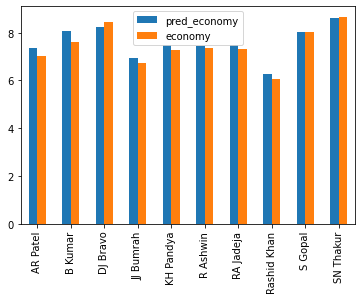

In [41]:
df = pd.DataFrame({'pred_economy': pred_economy,
                   'economy': economy}, index=bowler)
ax = df.plot.bar(rot='vertical')